# **SETUP**
All necessary libraries are imported here.

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight

# **DATASET ANALYSIS**
This block inspects the dataset to understand its structure and class distribution.

In [ ]:
def count_images(dataset_path):
    """Counts images in train, test, and validation splits."""
    counts = {}
    for split in ["train", "test", "val"]:
        split_path = os.path.join(dataset_path, split)
        if not os.path.isdir(split_path): continue
        counts[split] = {}
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if not f.startswith('.')])
                counts[split][class_name] = num_images
    return counts

dataset_dir = "dataset"
image_counts = count_images(dataset_dir)
for split, classes in image_counts.items():
    print(f"\n{split.upper()}:")
    for cls, num in classes.items():
        print(f"  {cls}: {num} images")


TRAIN:
  anemia: 215 images
  non-anemia: 214 images

TEST:
  anemia: 47 images
  non-anemia: 52 images

VAL:
  anemia: 46 images
  non-anemia: 46 images


# **CONFIGURATION AND DATA LOADING**
Define constants and load the datasets correctly.

In [ ]:
TRAIN_DIR = "dataset/train"
VAL_DIR = "dataset/val"
TEST_DIR = "dataset/test"
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

unbatched_train_ds = image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=None
)
train_ds = image_dataset_from_directory(
    TRAIN_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = image_dataset_from_directory(
    VAL_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = image_dataset_from_directory(
    TEST_DIR, label_mode='int', image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"\n✅ Class names found: {class_names}")

Found 429 files belonging to 2 classes.
Found 429 files belonging to 2 classes.
Found 92 files belonging to 2 classes.
Found 99 files belonging to 2 classes.

✅ Class names found: ['anemia', 'non-anemia']


# **DATA AUGMENTATION AND PIPELINE**

In [ ]:
# --- UPGRADE: Using slightly stronger augmentations ---
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3), # Increased
    tf.keras.layers.RandomZoom(0.3),   # Increased
    tf.keras.layers.RandomContrast(0.3), # Increased
    tf.keras.layers.RandomBrightness(0.3), # Increased
], name='data_augmentation')

def prepare_train_data(image, label):
    image = data_augmentation(image, training=True)
    image = preprocess_input(image)
    return image, label

def prepare_val_test_data(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_ds.map(prepare_train_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(prepare_val_test_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(prepare_val_test_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
print("\n✅ Data pipeline configured with stronger augmentation.")

train_labels = np.array([y for x, y in unbatched_train_ds])
class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels), y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights calculated: {class_weight_dict}")


✅ Data pipeline configured with stronger augmentation.
✅ Class weights calculated: {0: np.float64(0.9976744186046511), 1: np.float64(1.0023364485981308)}


# **DEFINITIVE MODEL DEFINITION (USING MOBILENETV3)**

In [ ]:
K.clear_session()

base_model = MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    minimalistic=True
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5), # Strong dropout
    Dense(1, activation="sigmoid")
])

# --- UPGRADE: Using AdamW and BinaryCrossentropy with Label Smoothing ---
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.1), # Powerful regularization
    metrics=["accuracy"]
)
print("\n✅ Definitive model built and compiled successfully.")
model.summary()


2128592/2128592 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step

✅ Definitive model built and compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       441,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,577 (1.68 MB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 441,000 (1.68 MB)

# **STAGE 1 TRAINING (FEATURE EXTRACTION)**
Train the custom head of the model with the base model frozen.

In [ ]:
print("\n--- Starting Training Stage 1: Feature Extraction ---")
# --- UPGRADE: Using more patient callbacks ---
es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[es, reduce_lr],
    class_weight=class_weight_dict
)


--- Starting Training Stage 1: Feature Extraction ---
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.6107 - loss: 0.6852 - val_accuracy: 0.7500 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7040 - loss: 0.6331 - val_accuracy: 0.7609 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7436 - loss: 0.5799 - val_accuracy: 0.7717 - val_loss: 0.5494 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7529 - loss: 0.5731 - val_accuracy: 0.7717 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8159 - loss: 0.5040 - val_accuracy: 0.7717 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7879 - loss: 0.5053 - val_accuracy: 0.7500 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━

# **STAGE 2 TRAINING (FINE-TUNING)**
Unfreeze all layers and continue training with an ultra-low learning rate.

In [ ]:
print("\n--- Starting Training Stage 2: Gradual Fine-Tuning ---")
# --- UPGRADE: Unfreeze only the top layers for stable fine-tuning ---
base_model.trainable = True

# Fine-tune from this layer onwards. MobileNetV3Small has ~220 layers.
# Unfreezing the last ~40 is a good, stable starting point.
fine_tune_at = -40

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# --- Re-compile with a low learning rate ---
model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5), # Low LR for fine-tuning
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)
print("\nModel re-compiled for fine-tuning.")

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[es, reduce_lr], # Reuse the same patient callbacks
    class_weight=class_weight_dict
)
print("\n--- Training Complete ---")

model.save("anemia_model.keras")
print("\n✅ Final model saved to anemia_model.keras")


--- Starting Training Stage 2: Gradual Fine-Tuning ---

Model re-compiled for fine-tuning.
Epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.8089 - loss: 0.4931 - val_accuracy: 0.7609 - val_loss: 0.5402 - learning_rate: 1.0000e-05
Epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8205 - loss: 0.5061 - val_accuracy: 0.7717 - val_loss: 0.5408 - learning_rate: 1.0000e-05
Epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8182 - loss: 0.4941 - val_accuracy: 0.7717 - val_loss: 0.5414 - learning_rate: 1.0000e-05
Epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8135 - loss: 0.4937 - val_accuracy: 0.7717 - val_loss: 0.5424 - learning_rate: 1.0000e-05
Epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8159 - loss: 0.4864 - val_accuracy: 0.7717 - val_loss: 0.5431 - learning_rate: 1.0000e-05
Epoch 29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.8159 - loss: 0.4893 - val_accuracy: 0.7717 - val_loss: 

# **In số liệu model**


--- Evaluating Final Model ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8182 - loss: 0.4824
Test Accuracy: 0.82
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step

Classification Report:
              precision    recall  f1-score   support

      anemia       0.78      0.85      0.82        47
  non-anemia       0.85      0.79      0.82        52

    accuracy                           0.82        99
   macro avg       0.82      0.82      0.82        99
weighted avg       0.82      0.82      0.82        99



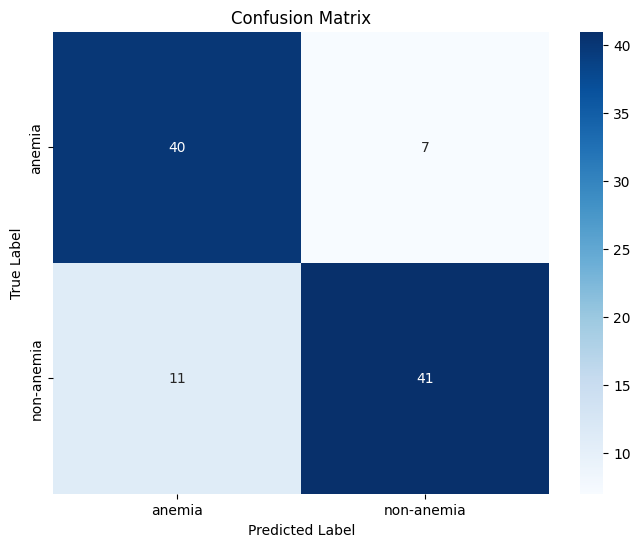

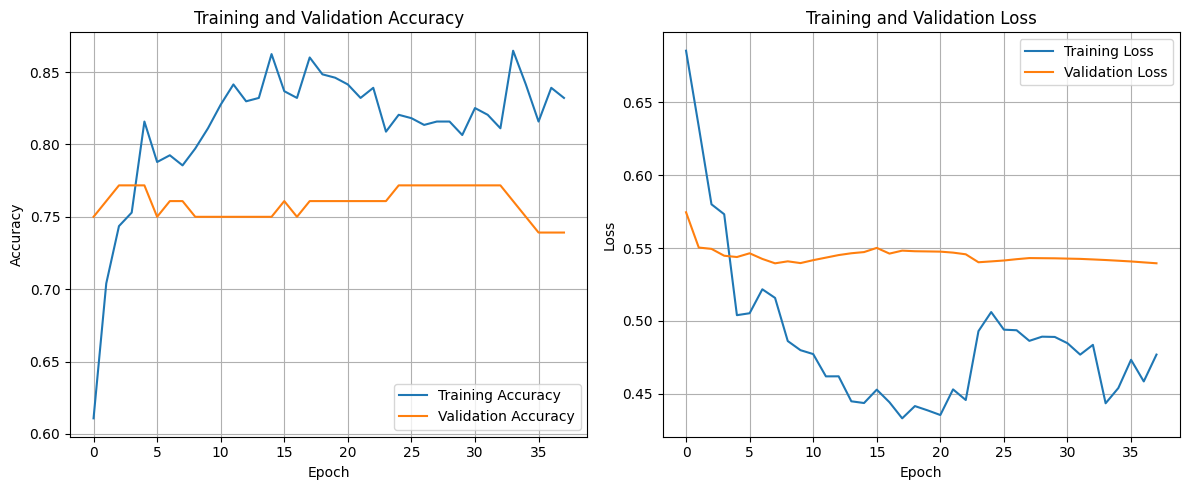

In [ ]:
print("\n--- Evaluating Final Model ---")
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

acc = history.history.get('accuracy', []) + history_finetune.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', []) + history_finetune.history.get('val_accuracy', [])
loss = history.history.get('loss', []) + history_finetune.history.get('loss', [])
val_loss = history.history.get('val_loss', []) + history_finetune.history.get('val_loss', [])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


--- Generating Core Performance Curves ---


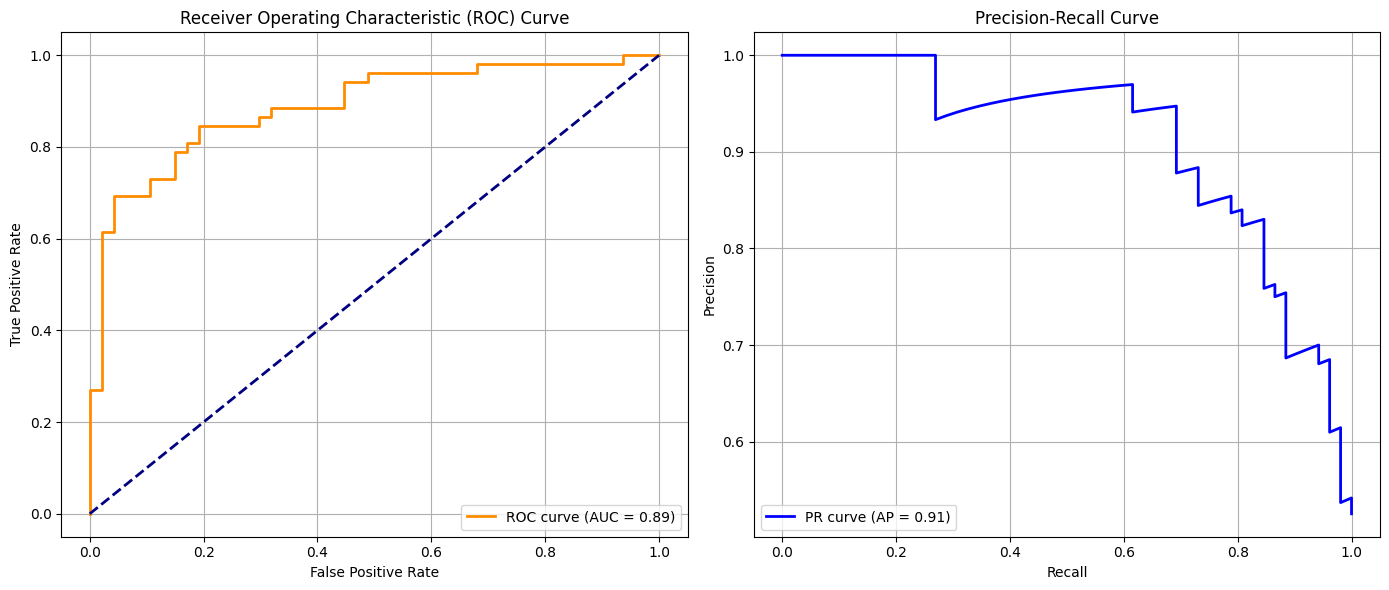


--- Generating Model Calibration Curve ---


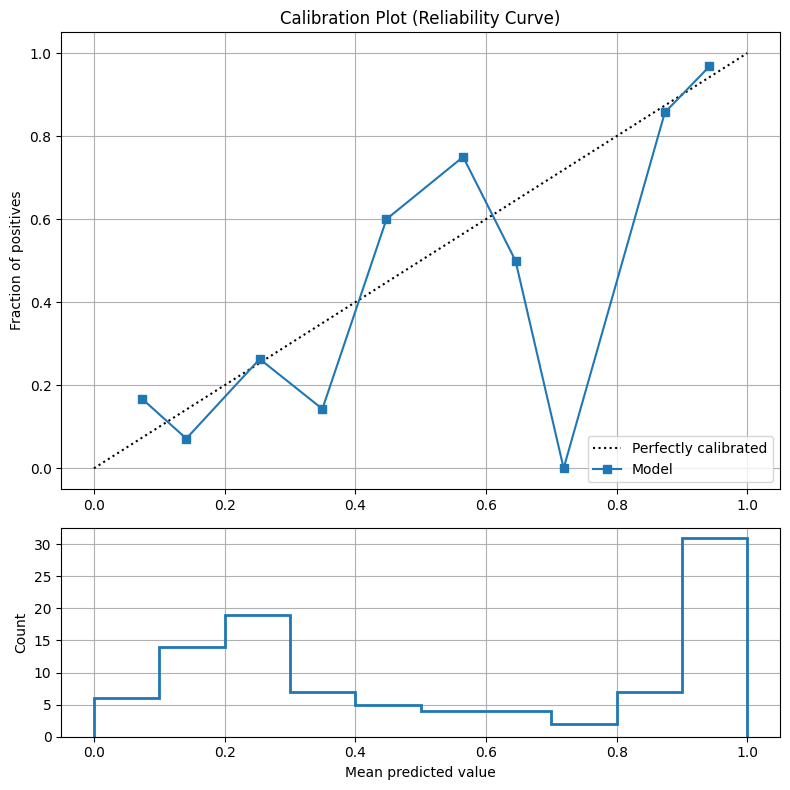

In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

def plot_roc_and_pr_curves(y_true, y_pred_probs):
    """Plots the ROC and Precision-Recall curves side-by-side."""
    plt.figure(figsize=(14, 6))

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right"); plt.grid(True)

    # --- Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    avg_precision = average_precision_score(y_true, y_pred_probs)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left"); plt.grid(True)

    plt.tight_layout(); plt.show()

print("\n--- Generating Core Performance Curves ---")
plot_roc_and_pr_curves(y_true, y_pred_probs)

def plot_calibration_curve(y_true, y_pred_probs):
    """Plots the calibration curve to show model confidence reliability."""
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_probs, n_bins=10)
    
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
    ax2.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives"); ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right"); ax1.set_title('Calibration Plot (Reliability Curve)'); ax1.grid(True)
    ax2.set_xlabel("Mean predicted value"); ax2.set_ylabel("Count"); ax2.grid(True)
    
    plt.tight_layout(); plt.show()

print("\n--- Generating Model Calibration Curve ---")
plot_calibration_curve(y_true, y_pred_probs)